# Quantum Imaginary Time Evolution

In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

from scipy.linalg import lstsq
from scipy.linalg import eigh

from pprint import pprint
from tqdm import tqdm

# Everything we need from Qiskit
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute, Aer
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools import parallel_map

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16,8)})
sns.set()

import itertools

import sys
sys.path.append("../src/")
from hamiltonian import *
from utils import *
from qiskit_circuits import *
from qite import *

## Testing operator construction

### Graycode

In [3]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits

## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits)

## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
for p in commuting_sets:
    print(p, commuting_sets[p])


XX ['II', 'IX', 'XI', 'XX']
XY ['IY', 'XY']
XZ ['IZ', 'XZ']
YX ['YI', 'YX']
YY ['YY']
YZ ['YZ']
ZX ['ZI', 'ZX']
ZY ['ZY']
ZZ ['ZZ']


### Jordan Wigner

In [2]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)

## Get list of sigmas (all pauli terms with odd number Y gates)
n_qubits=H_qubit.N_qubits

## vector of WeightedPauliOperators representing vector Sigma
sigmas=sigma_terms(n_qubits,encoding="jordan_wigner")
# for sigma in sigmas:
#     print(sigma.print_details())
## Construct b
b_pauli_terms=b_terms(H_qubit,sigmas)
# for bI in b_pauli_terms:
#     print(bI)
      
## Construct S
S_pauli_terms=S_terms(sigmas)

pauli_set=get_intersection_pauli_terms(H_qubit,b_pauli_terms,S_pauli_terms)

commuting_sets=get_commuting_sets(sorted(pauli_set))
print(f"Num commuting sets: {len(commuting_sets)}")
for p in commuting_sets:
    print(p, commuting_sets[p])
    


Num commuting sets: 18
ZZZ ['III', 'IIZ', 'IZI', 'IZZ', 'ZII', 'ZIZ', 'ZZI', 'ZZZ']
XXX ['IXX', 'XIX', 'XXI']
XXY ['IXY', 'XIY']
XYX ['IYX', 'XYI']
YYY ['IYY', 'YIY', 'YYI']
XXZ ['XXZ']
XYZ ['XYZ']
XZX ['XZX']
XZY ['XZY']
YXX ['YIX', 'YXI']
YXZ ['YXZ']
YYZ ['YYZ']
YZX ['YZX']
YZY ['YZY']
ZXX ['ZXX']
ZXY ['ZXY']
ZYX ['ZYX']
ZYY ['ZYY']


# Quantum imaginary time evolution

## Graycode $N_\mathrm{max}=4$

In [2]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'qasm_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None
    }

parameters=set_qite_parameters(parameters)

No value for parameter qlanczos provided.
Setting qlanczos to default value False.
No value for parameter krylov_threshold provided.
Setting krylov_threshold to default value 0.99999.
No value for parameter qite_threshold provided.
Setting qite_threshold to default value 0.01.
No value for parameter show_progress provided.
Setting show_progress to default value True.

Experiment parameters
{'N_cpus': 1,
 'N_shots': 10000,
 'N_time_steps': 30,
 'N_trials': 1,
 'Nmax': 4,
 'Qite_threshold': 0.01,
 'backend': 'qasm_simulator',
 'delta_time': 0.01,
 'device_name': None,
 'encoding': 'gray_code',
 'initialization': 'single_state',
 'interaction': 'toy',
 'krylov_threshold': 0.99999,
 'layout': None,
 'merge_step': None,
 'mitigate_meas_error': False,
 'output_dir': 'outputs',
 'qite_threshold': 0.01,
 'qlanczos': False,
 'show_progress': True}



In [7]:
backend = 'statevector_simulator'
parameters['backend']='statevector_simulator'
parameters['qite_threshold']=1e-10
parameters['Nmax']=4

H = hamiltonian_matrix(Nmax=parameters['Nmax'], J=1, interaction=parameters['interaction'])
H_qubit = GrayCodeHamiltonian(H)

sv_energies_30 =qite_experiment2(H_qubit,parameters)
# sv_energies_5=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=1e-10)

# print(sv_energies_20)

100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


In [6]:
parameters['backend']='qasm_simulator'
Energy_table=[]
for threshold in [1e-1,1e-2,1e-5,1e-10]:
#     backend = 'qasm_simulator'
#     Energies=qite_experiment(H_qubit,time_steps,delta_time,backend,initialization,A_threshold=threshold)
    parameters['qite_threshold']=threshold
    Energies=qite_experiment2(H_qubit,parameters)
    Energy_table.append(Energies)

100%|██████████| 30/30 [00:38<00:00,  1.27s/it]


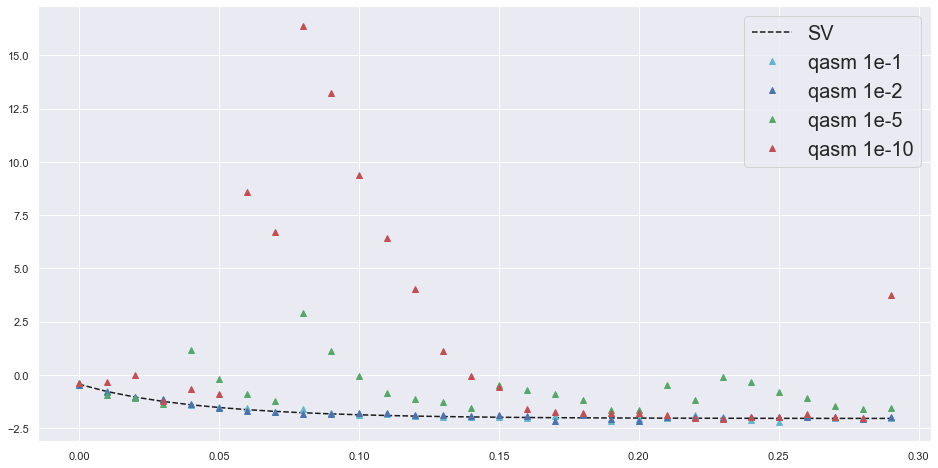

In [8]:
time=[delta_time*t for t in range(parameters["N_time_steps"])]
plt.plot(time,sv_energies_30,'k--',label="SV")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.legend(prop={'size': 20})

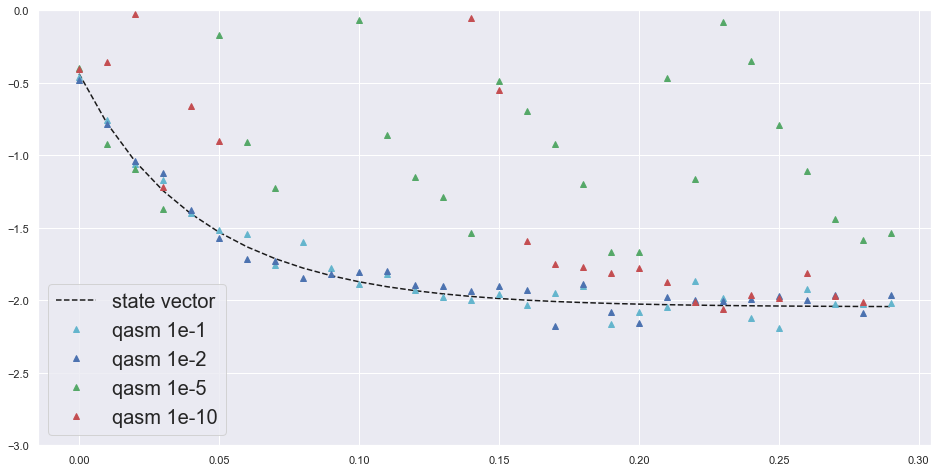

In [10]:
time=[delta_time*t for t in range(parameters["N_time_steps"])]
plt.plot(time,sv_energies_30,'k--',label="state vector")
plt.plot(time,Energy_table[0],'c^',label="qasm 1e-1")
plt.plot(time,Energy_table[1],'b^',label="qasm 1e-2")
plt.plot(time,Energy_table[2],'g^',label="qasm 1e-5")
plt.plot(time,Energy_table[3],'r^',label="qasm 1e-10")
plt.ylim(-3,0)
plt.legend(prop={'size': 20})

Testing different time steps.  Approximation of normalization coefficient requires $\Delta t\le0.1$ 

In [13]:
## setting parameters
parameters['qite_threshold']=1e-2

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

for delta_time in [0.001,0.01,0.05]:
    parameters['delta_time']=delta_time
    
    parameters['backend']='qasm_simulator'
    Energy_table_time_qasm.append(qite_experiment2(H_qubit,parameters))

    parameters['backend']='statevector_simulator'
    Energy_table_time_sv.append(qite_experiment2(H_qubit,parameters))


100%|██████████| 30/30 [00:03<00:00,  8.15it/s]


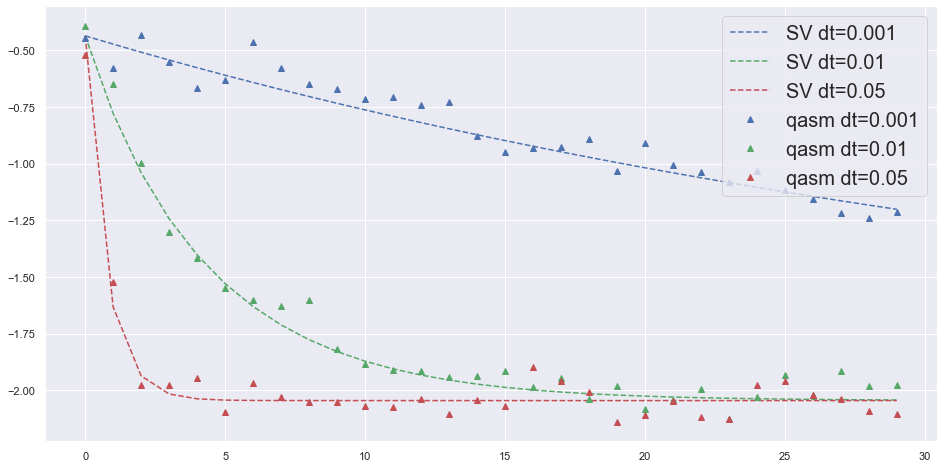

In [15]:
time=[t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.05")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.05")
plt.legend(prop={'size': 20})

Testing merge $\{A+i\}$ into single operators after different number of iterations.

In [3]:
parameters['backend']='statevector_simulator'
parameters['delta_time']=0.01
parameters['qite_threshold']=1e-2

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

merge_iterations=[0,1,2,10,25]
Energy_table_step=[]
for cs in merge_iterations:
    if cs==0:
        parameters['merge_step']=None
    else:
        parameters['merge_step']=cs
        
    Energy_table_step.append(qite_experiment2(H_qubit,parameters))

100%|██████████| 30/30 [00:02<00:00, 10.21it/s]


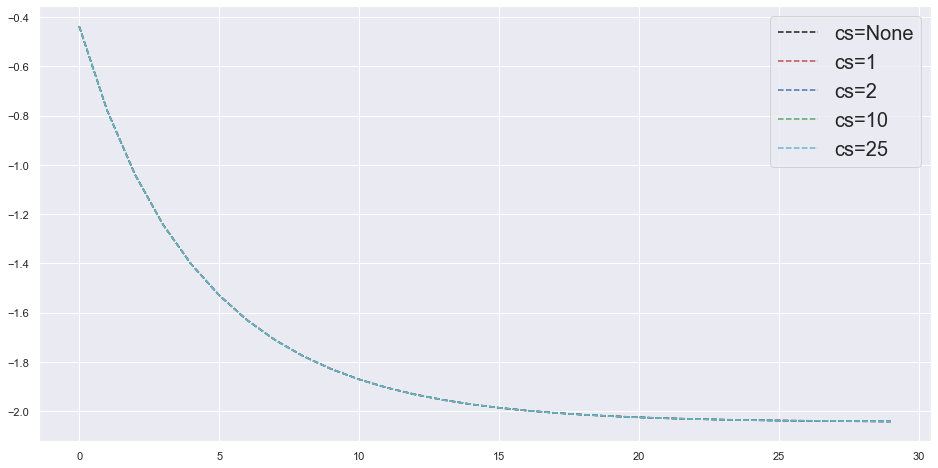

In [4]:
time=[t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_step[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step[1],'r--',label="cs=1")
plt.plot(time,Energy_table_step[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step[4],'g--',label="cs=10")
plt.plot(time,Energy_table_step[4],'c--',label="cs=25")
plt.plot()
plt.legend(prop={'size': 20})


In [5]:
parameters['backend']='qasm_simulator'
parameters['delta_time']=0.01
parameters['qite_threshold']=1e-2

Energy_table_step_qasm=[]
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)


merge_iterations=[0,1,2,10,25]
for cs in merge_iterations:
    if cs==0:
        parameters['merge_step']=None
    else:
        parameters['merge_step']=cs
        
    Energy_table_step_qasm.append(qite_experiment2(H_qubit,parameters))

100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


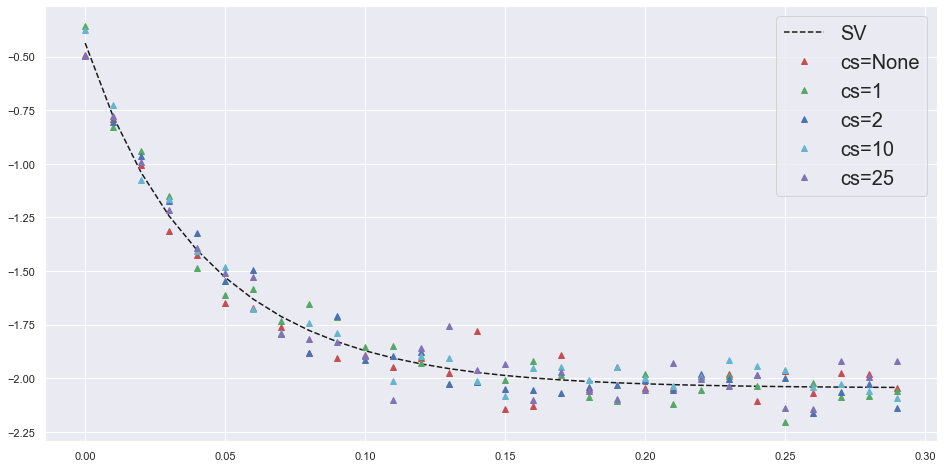

In [7]:
time=[0.01*t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_step[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm[0],'r^',label="cs=None")
plt.plot(time,Energy_table_step_qasm[1],'g^',label="cs=1")
plt.plot(time,Energy_table_step_qasm[2],'b^',label="cs=2")
plt.plot(time,Energy_table_step_qasm[3],'c^',label="cs=10")
plt.plot(time,Energy_table_step_qasm[4],'m^',label="cs=25")
plt.plot()
plt.legend(prop={'size': 20})

## Jordan Wigner Encoding $N_\mathrm{max}=4$

In [8]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'jordan_wigner',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None
    }

parameters=set_qite_parameters(parameters)

No value for parameter qlanczos provided.
Setting qlanczos to default value False.
No value for parameter krylov_threshold provided.
Setting krylov_threshold to default value 0.99999.
No value for parameter qite_threshold provided.
Setting qite_threshold to default value 0.01.
No value for parameter show_progress provided.
Setting show_progress to default value True.

Experiment parameters
{'N_cpus': 1,
 'N_shots': 10000,
 'N_time_steps': 30,
 'N_trials': 1,
 'Nmax': 4,
 'Qite_threshold': 0.01,
 'backend': 'statevector_simulator',
 'delta_time': 0.01,
 'device_name': None,
 'encoding': 'jordan_wigner',
 'initialization': 'single_state',
 'interaction': 'toy',
 'krylov_threshold': 0.99999,
 'layout': None,
 'merge_step': None,
 'mitigate_meas_error': False,
 'output_dir': 'outputs',
 'qite_threshold': 0.01,
 'qlanczos': False,
 'show_progress': True}



In [12]:
## setting parameters
parameters['qite_threshold']=1e-2
parameters['N_time_steps']=50
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)

Energy_table_time_sv=[]
Energy_table_time_qasm=[]

for delta_time in [0.001,0.01,0.05]:
    parameters['delta_time']=delta_time
    
    parameters['backend']='qasm_simulator'
    Energy_table_time_qasm.append(qite_experiment2(H_qubit,parameters))

    parameters['backend']='statevector_simulator'
    Energy_table_time_sv.append(qite_experiment2(H_qubit,parameters))


100%|██████████| 50/50 [01:42<00:00,  2.05s/it]


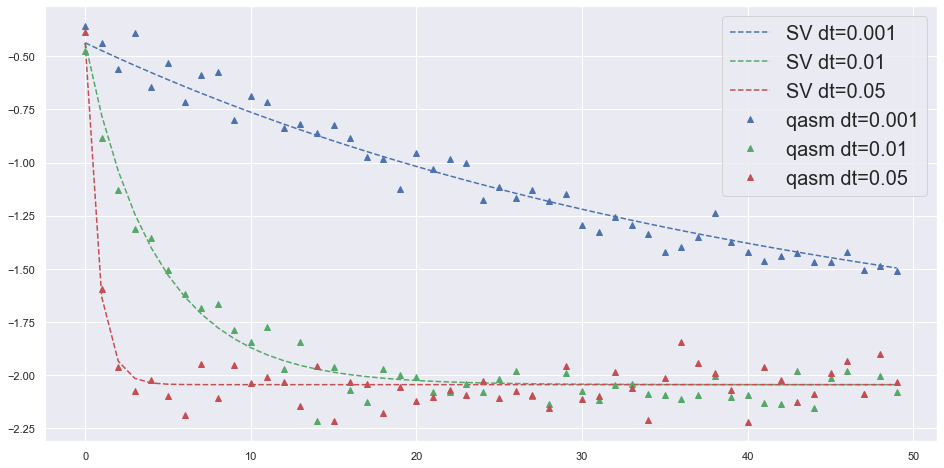

In [13]:
time=[t for t in range(parameters["N_time_steps"])]
plt.plot(time,Energy_table_time_sv[0],'b--',label="SV dt=0.001")
plt.plot(time,Energy_table_time_sv[1],'g--',label="SV dt=0.01")
plt.plot(time,Energy_table_time_sv[2],'r--',label="SV dt=0.05")

plt.plot(time,Energy_table_time_qasm[0],'b^',label="qasm dt=0.001")
plt.plot(time,Energy_table_time_qasm[1],'g^',label="qasm dt=0.01")
plt.plot(time,Energy_table_time_qasm[2],'r^',label="qasm dt=0.05")
plt.legend(prop={'size': 20})

## 3 qubits

In [6]:
parameters = {
    'Nmax' : 14,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'statevector_simulator',
    'N_trials' : 1,
    'N_time_steps': 50,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None
    }

parameters=set_qite_parameters(parameters,verbose=False)

In [7]:
# # time_steps=5
# time_steps=100
# delta_time=0.01
# verbose=False
# backend = 'statevector_simulator'
# initialization="single_state"
H = hamiltonian_matrix(
    Nmax=parameters['Nmax'],
    J=1,
    interaction=parameters['interaction']
    )
H_qubit = GrayCodeHamiltonian(H)
n_qubits=H_qubit.N_qubits
print(n_qubits)

Energy_table_step_3q=[]
merge_iterations=[None,1,2,10,25]
dummy_index=0
for merge_step in merge_iterations:
    parameters['merge_step']=merge_step
    Energy_table_step_3q.append(qite_experiment2(H_qubit,parameters))

  0%|          | 0/50 [00:00<?, ?it/s]

3


100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


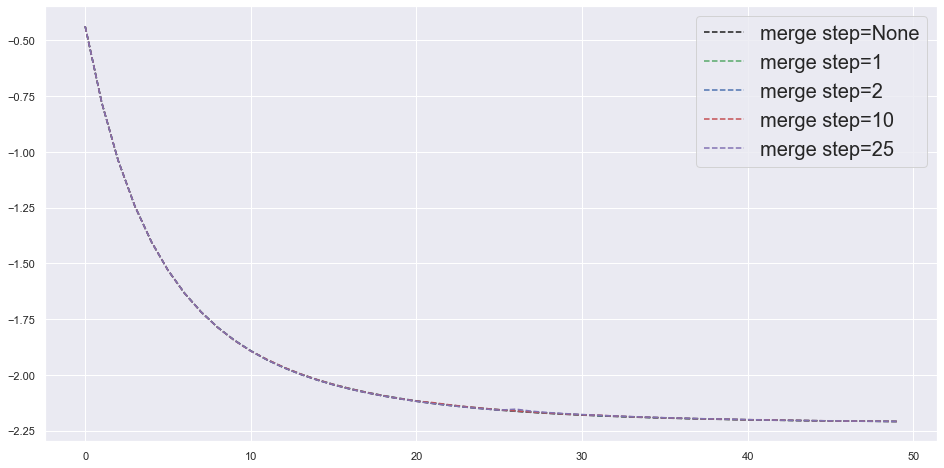

In [8]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,Energy_table_step_3q[0],'k--',label="merge step=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="merge step=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="merge step=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="merge step=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="merge step=25")
plt.legend(prop={'size': 20})

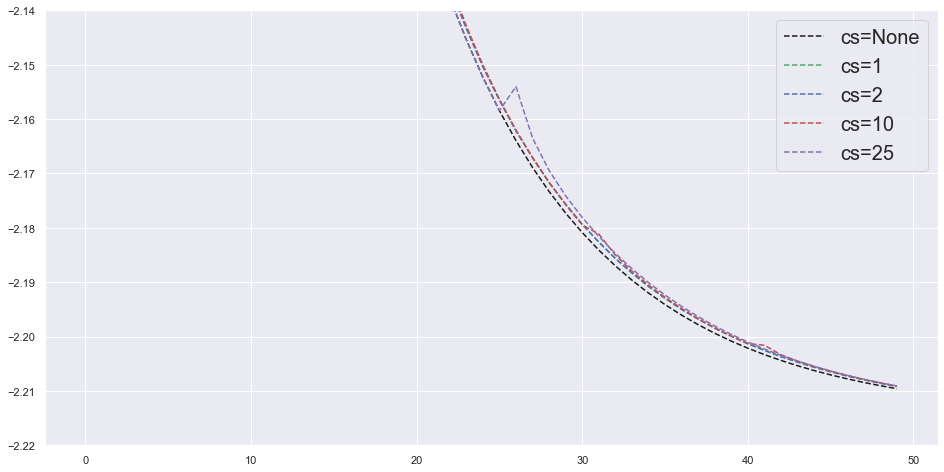

In [12]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,Energy_table_step_3q[0],'k--',label="cs=None")
plt.plot(time,Energy_table_step_3q[1],'g--',label="cs=1")
plt.plot(time,Energy_table_step_3q[2],'b--',label="cs=2")
plt.plot(time,Energy_table_step_3q[3],'r--',label="cs=10")
plt.plot(time,Energy_table_step_3q[4],'m--',label="cs=25")
plt.ylim(-2.22,-2.14)
plt.legend(prop={'size': 20})

In [13]:
# time_steps=5
time_steps=100
delta_time=0.01
verbose=False
parameters['backend'] = 'qasm_simulator'

Energy_table_step_qasm_3q=[]
merge_iterations=[1,2,10]
for merge_step in merge_iterations:
    parameters['merge_step']=merge_step
    Energy_table_step_qasm_3q.append(qite_experiment2(H_qubit,parameters))

100%|██████████| 50/50 [04:31<00:00,  5.42s/it]


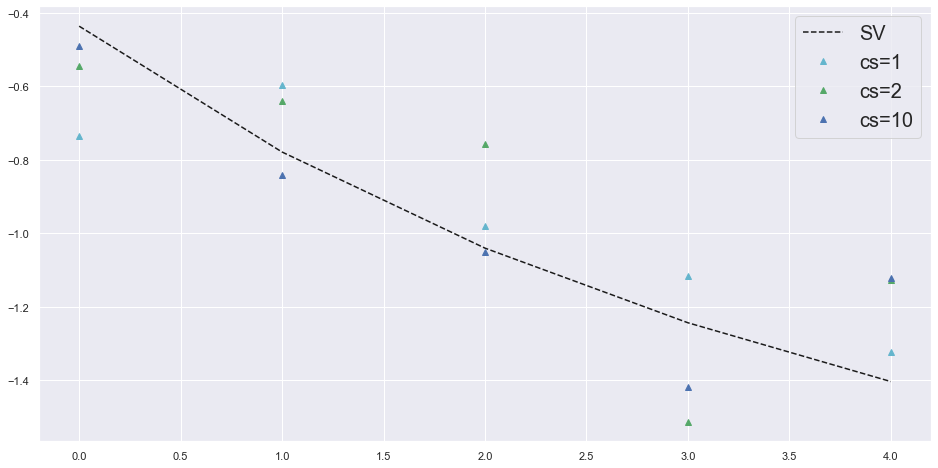

In [16]:
time=[t for t in range(parameters['N_time_steps'])]
plt.plot(time,Energy_table_step_3q[0],'k--',label="SV")
plt.plot(time,Energy_table_step_qasm_3q[0],'c^',label="cs=1")
plt.plot(time,Energy_table_step_qasm_3q[1],'g^',label="cs=2")
plt.plot(time,Energy_table_step_qasm_3q[2],'b^',label="cs=10")
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

## Jordan Wigner

In [18]:
time_steps=20
delta_time=0.01
verbose=False
backend = 'statevector_simulator'
initialization="single_state"

qasm_energies_table_cs=[]

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = JordanWignerHamiltonian(H)
n_qubits=H_qubit.N_qubits
# print(H_qubit.matrix)
print(eigh(H_qubit.matrix)[0])
# print(H_qubit.pauli_partitions)

Energy_table_step_2q_jw=[]
merge_iterations=[None,1,2,10]
for cs in merge_iterations:
    Energy_table_step_2q_jw.append(
        qite_experiment(
            H_qubit,time_steps,delta_time,backend,initialization,
            encoding="jordan_wigner",A_threshold=1e-10,cstep=cs)
    )

  0%|          | 0/20 [00:00<?, ?it/s]

[-2.0456709   0.          6.51591083  8.56158173 22.50183716 24.54750806
 31.06341889 33.10908979]


100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


-2.045670898406403


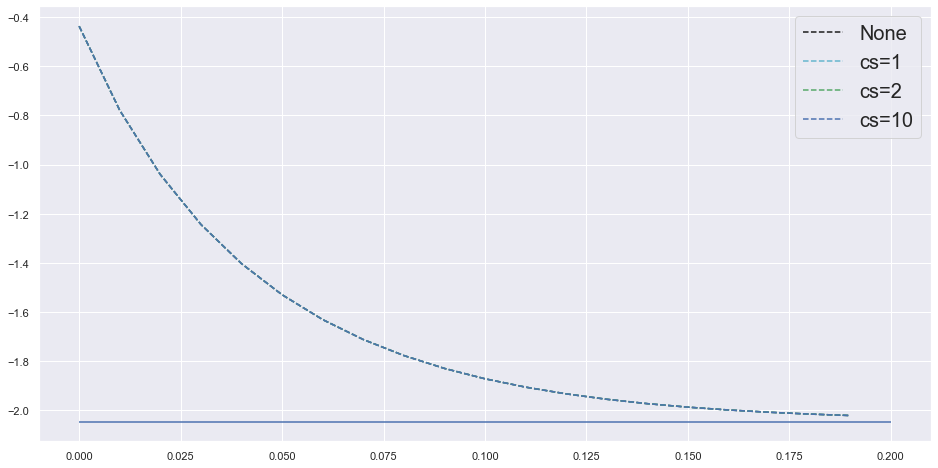

In [19]:
exact_E=eigh(H_qubit.matrix)[0][0]
print(exact_E)
time=[delta_time*t for t in range(time_steps)]
plt.plot(time,Energy_table_step_2q_jw[0],'k--',label="None")
plt.plot(time,Energy_table_step_2q_jw[1],'c--',label="cs=1")
plt.plot(time,Energy_table_step_2q_jw[2],'g--',label="cs=2")
plt.plot(time,Energy_table_step_2q_jw[3],'b--',label="cs=10")
plt.hlines(exact_E,0,delta_time*time_steps)
# plt.xlim(60,100)
# plt.ylim(-2.2151,-2.2145)
plt.legend(prop={'size': 20})

In [22]:
## Testing
N_states=4
encoding="gray_code"
N_qubits = int(np.ceil(np.log2(N_states)))

measurement_idx="X"*N_qubits
thetas = np.random.uniform(low=-np.pi/2, high=np.pi/2,size=N_states-1)

circuit=variational_circuit(encoding,thetas,measurement_idx,"qasm_simulator",num_cnot_pairs=1,num_folding=1)
# circuit.draw(output="mpl",filename="circuit.pdf")
# circuit.draw()


# CNOT extrapolation

In [3]:
H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)
evolution_set=[H_qubit.weighted_pauli]
time=1
num_cnot_pairs=0


q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit=append_evolution_circuit(q,evolution_set,time,circuit,num_cnot_pairs)
print(circuit.decompose().draw())

num_cnot_pairs=1
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit=initialize_circuit(q,c)
circuit=append_evolution_circuit(q,evolution_set,time,circuit,num_cnot_pairs)
print(circuit.decompose().draw())


                                          ┌──────────┐            »
q4_0: ──────────────■──────────────────■──┤ U2(0,pi) ├────────────»
      ┌──────────┐┌─┴─┐┌────────────┐┌─┴─┐├──────────┤┌──────────┐»
q4_1: ┤ U2(0,pi) ├┤ X ├┤ U1(7.8262) ├┤ X ├┤ U2(0,pi) ├┤ U2(0,pi) ├»
      └──────────┘└───┘└────────────┘└───┘└──────────┘└──────────┘»
c2_0: ════════════════════════════════════════════════════════════»
                                                                  »
c2_1: ════════════════════════════════════════════════════════════»
                                                                  »
«                                                          ┌──────────┐»
«q4_0: ─────────────────────────────■───────────────────■──┤ U2(0,pi) ├»
«      ┌─────────────┐┌──────────┐┌─┴─┐┌─────────────┐┌─┴─┐└──────────┘»
«q4_1: ┤ U1(-7.8262) ├┤ U2(0,pi) ├┤ X ├┤ U1(-4.2866) ├┤ X ├────────────»
«      └─────────────┘└──────────┘└───┘└─────────────┘└───┘            »
«c2_0: ════════════════

In [12]:
parameters = {
    'Nmax' : 4,
    'interaction':"toy",
    'encoding' : 'gray_code',
    'initialization' : 'single_state',
    'backend' : 'qasm_simulator',
    'N_trials' : 1,
    'N_time_steps': 30,
    'delta_time' : 0.01,
    'merge_step' : None,
    'Qite_threshold' : 1e-2, 
    'N_shots' : 10000,
    'device_name' : None,
    'mitigate_meas_error' : False,
    'N_cpus' : 1,
    'output_dir': 'outputs',
    'layout' : None,
    'number_cnot_pairs': 1
    }

parameters=set_qite_parameters(parameters,verbose=False)

In [13]:
# parameters['backend']='statevector_simulator'
# parameters['delta_time']=0.01
# parameters['qite_threshold']=1e-2

H = hamiltonian_matrix(Nmax=4,J=1,interaction="toy")
H_qubit = GrayCodeHamiltonian(H)

        
energies=qite_experiment2(H_qubit,parameters)

100%|██████████| 30/30 [00:24<00:00,  1.22it/s]


In [14]:
print(energies)

[-0.40106085 -0.84445935 -1.00407122 -1.1092187  -1.43749107 -1.58537253
 -1.58718225 -1.74222777 -1.82756625 -1.76716141 -1.79151369 -1.90632571
 -1.98083753 -1.94799112 -1.95395863 -2.02188119 -2.00492749 -2.01203801
 -2.20677605 -1.99959998 -1.91487007 -2.06320737 -1.98649705 -1.87748424
 -1.97750053 -2.00027059 -2.06761843 -1.99049747 -2.11225665 -2.08045281]
